In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import os

# Path to the dataset
base_dir = "/content/drive/MyDrive/datasetsampah"

# Data augmentation to enhance data variability
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation data
)

# Creating generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Calculating steps_per_epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

# Using a pretrained model (MobileNetV2)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze pretrained layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compiling the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callback for early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop]
)

# Evaluating the model
loss, accuracy = model.evaluate(validation_generator)
print(f"Model Accuracy: {accuracy:.2f}")


Found 12785 images belonging to 2 classes.
Found 3195 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


399/399 ━━━━━━━━━━━━━━━━━━━━ 2424s 6s/step - accuracy: 0.9227 - loss: 0.2343 - val_accuracy: 0.9776 - val_loss: 0.0785
Epoch 2/10
  1/399 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9375 - loss: 0.1936

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9375 - loss: 0.1936 - val_accuracy: 1.0000 - val_loss: 0.0316
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 226s 560ms/step - accuracy: 0.9627 - loss: 0.1019 - val_accuracy: 0.9747 - val_loss: 0.0845
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 1.0000 - loss: 0.0203 - val_accuracy: 1.0000 - val_loss: 0.0532
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 222s 549ms/step - accuracy: 0.9690 - loss: 0.0880 - val_accuracy: 0.9751 - val_loss: 0.0774
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 443ms/step - accuracy: 0.9743 - loss: 0.0769
Model Accuracy: 0.97


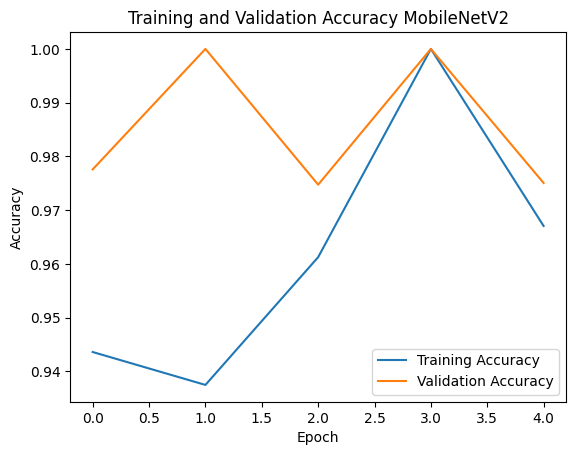

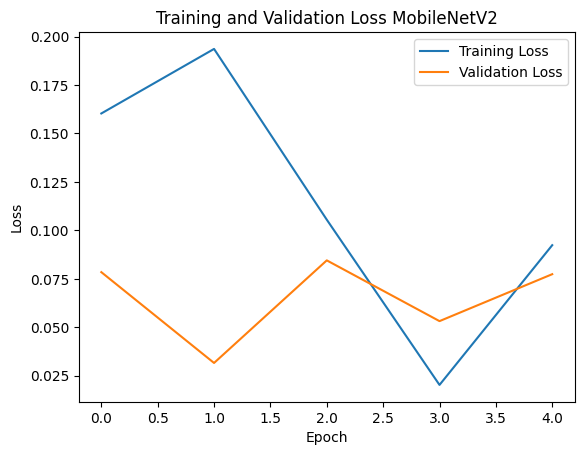

In [ ]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       350
         1.0       0.99      0.99      0.99      2818

    accuracy                           0.98      3168
   macro avg       0.94      0.96      0.95      3168
weighted avg       0.98      0.98      0.98      3168


Summary Metrics:
Precision: 0.991
Recall: 0.987
F1-Score: 0.989


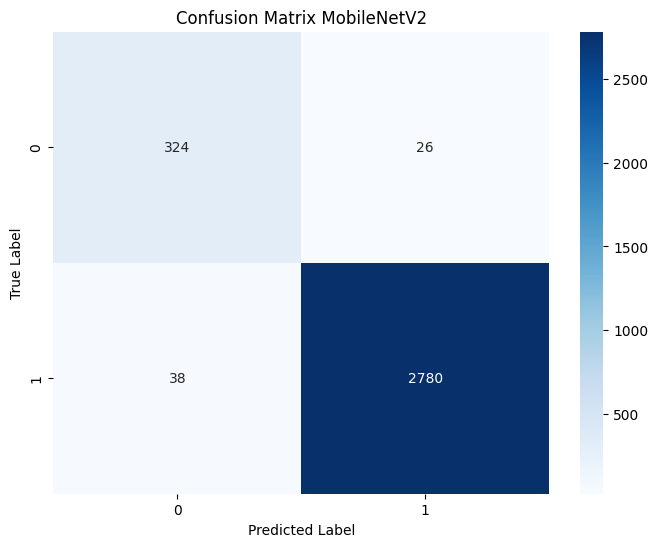

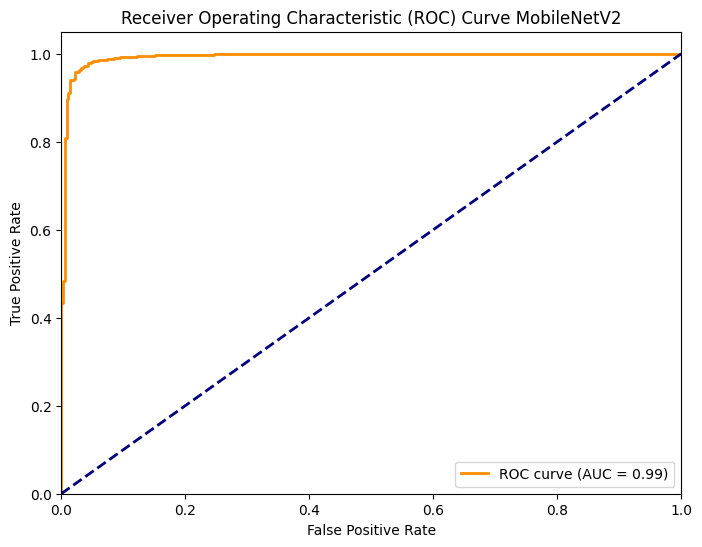

In [ ]:
# Proper evaluation code
validation_generator.reset()
y_pred = []
y_true = []

for i in range(validation_steps):
    x_batch, y_batch = next(validation_generator)
    pred_batch = model.predict(x_batch, verbose=0)
    y_pred.extend(pred_batch)
    y_true.extend(y_batch)

y_pred = np.array(y_pred)
y_true = np.array(y_true)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print classification metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred_binary))

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_binary, average='binary')

print("\nSummary Metrics:")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix MobileNetV2')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve MobileNetV2')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Menyimpan model dalam format .h5
model.save('/content/drive/MyDrive/datasetsampah/cnn_mnetv2.h5')

print("The model has successfully saved as 'cnn_mnetv2.h5' in Google Drive!")


The model has successfully saved as 'cnn_mnetv2.h5' in Google Drive!


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the model and image
model_path = '/content/drive/MyDrive/datasetsampah/cnn_mnetv2.h5'
image_path = '/content/drive/MyDrive/datasetsampah/compost/food_waste/food (4).png'

# Load the model
model = load_model(model_path)

# Preprocessing the image
img = load_img(image_path, target_size=(224, 224))  # Resize to match the model's input size
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
img_array = img_array / 255.0  # Normalize pixel values

# Prediction
prediction = model.predict(img_array)
class_labels = {0: 'Compost', 1: 'Recyclable'}  # Labels according to data order
predicted_class = class_labels[int(prediction[0] > 0.5)]

print(f"Prediction Result: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction Result: Compost


<ipython-input-23-479e681b0eb3>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]
